In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import sys,os
sys.path.append('./helper_functions')
sys.path.append('./helper_functions/bemColors_lib')
sys.path.append('../../Electrodes')
from helper_functions import plot_mesh
from bemColors import bemColors
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from bem import *
from bem.formats import stl

from multipoles import MultipoleControl
from plottingfuncns import *

from time import time
from helper_functions import run_job, write_pickle

In [20]:
# loading job config information
from toggle_job_here import job_directory
pkls = os.listdir(f'./jobs/{job_directory}/pkls')
filename = ''
for p in pkls:
    if "_info.pkl" in p:
        filename = p
        break

mesh_units,x0,y0,z0,grid,prefix = pickle.load(open(f'./jobs/{config_job_directory}/pkls/{filename}', 'rb'))
print('Prefix: ',prefix)

Prefix:  ./jobs/example/pkls/pyramidtrap


max potential 837.2887564733959
x =  0.0050000000000000044


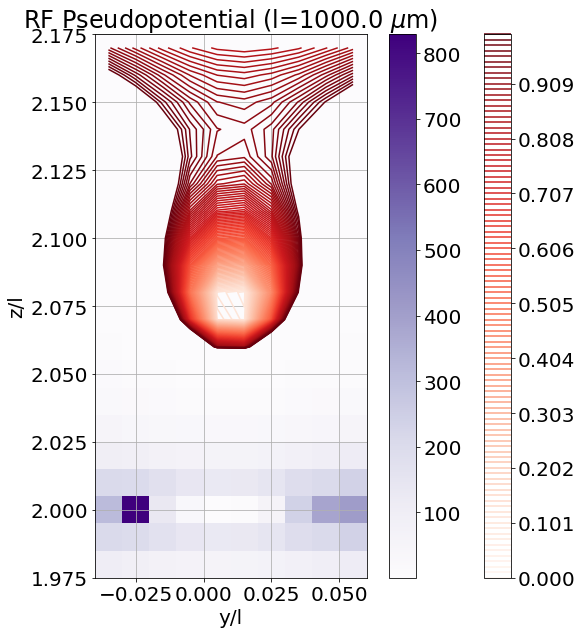

max potential 0.01718794182112409
x =  0.0050000000000000044


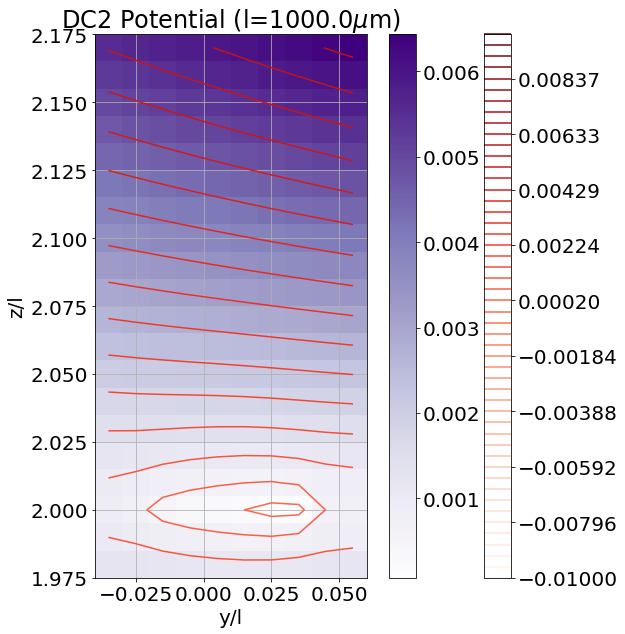

In [28]:
def plot_potentialf(electrode='RF', levels=np.linspace(0, 100e-2, 10),fout='fig.png',save=False):
    result = Result.from_pkl(prefix, electrode)
    if electrode=='RF':
        p = result.pseudo_potential
        title = f'RF Pseudopotential (l={np.round(mesh_units/1e-6,1)} $\mu$m)'
    else:
        p = result.potential
        title = f'{electrode} Potential (l={np.round(mesh_units/1e-6,1)}$\mu$m)'

    maxp = np.amax(p)
    print("max potential", maxp)

    x = grid.to_mgrid()
    print('x = ',grid.to_xyz()[0][p.shape[0]//2])
    x = grid.to_mgrid()[:, p.shape[0]//2]    # p.shape[0]/2 is in the middle of x.
    p = p[p.shape[0]//2]    # get a slice of yz plane at x = p.shape[0]/2 (x is along trap axis)
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect("equal")
#     ax.imshow(p, cmap=plt.cm.Reds)
#     plt.colorbar(ct)
    ct = ax.contour(x[1], x[2], p, levels=levels, cmap=plt.cm.Reds)
    cm = ax.pcolormesh(x[1], x[2], p, cmap=plt.cm.Purples)
    ax.set_ylabel('z/l')
    ax.set_xlabel('y/l')
    ax.set_title(title)
    ax.grid()
    plt.colorbar(ct)
    plt.colorbar(cm)
#     plt.tight_layout()

#     plt.savefig(electrode+'.png', bbox_inches='tight')
#     ax.set_ylim(0,0.4)
    plt.show()
    
plot_potentialf('RF', levels=np.linspace(0, 1, 100))
plot_potentialf('DC2', levels=np.linspace(-0.01, 0.01, 50))

In [29]:
nROI = 3
roi = [nROI, nROI, nROI]
order = 2

origin = [y0, z0, x0]
xl, yl, zl = origin
print('Origin ', origin)
controlled_electrodes = ['DC1','DC2','DC3','DC4','DC5','DC6','DC7','DC8','DC9','DC10','DC11','DC12','DC13','DC14','DC15','DC16','DC17','DC18','DC19','DC20','DC21']
used_multipoles =['Ex', 'Ey', 'Ez', 'U1', 'U2', 'U3','U4','U5']


# creating trap dictionary
x, y, z = grid.to_xyz()
nx = len(x)
ny = len(y)
nz = len(z)
ntotal = nx * ny * nz

trap = {'X': y,
        'Y': z,
        'Z': x}
    
trap['electrodes'] = {}
for ele in controlled_electrodes:
    result = Result.from_pkl(prefix, ele)
    p = result.potential
    p = np.swapaxes(p, 0, 2)
    p = np.swapaxes(p, 0, 1)
    trap['electrodes'][ele] = {'potential': p}
        
    
s = MultipoleControl(trap, origin, roi, controlled_electrodes, used_multipoles, order)

print('Multipole names:', s.multipole_names)
print('Normalization factors:', s.normalization_factors)
print(s.electrode_names)

Origin  [0.01, 2.075, 0.0]
Multipole names: ['C', 'Ey', 'Ez', 'Ex', 'U3', 'U4', 'U2', 'U5', 'U1']
Normalization factors: [0.28209479 0.48860251 0.48860251 0.48860251 1.09254843 1.09254843
 0.63078313 1.09254843 0.54627422]
['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'DC17', 'DC18', 'DC19', 'DC20', 'DC21']


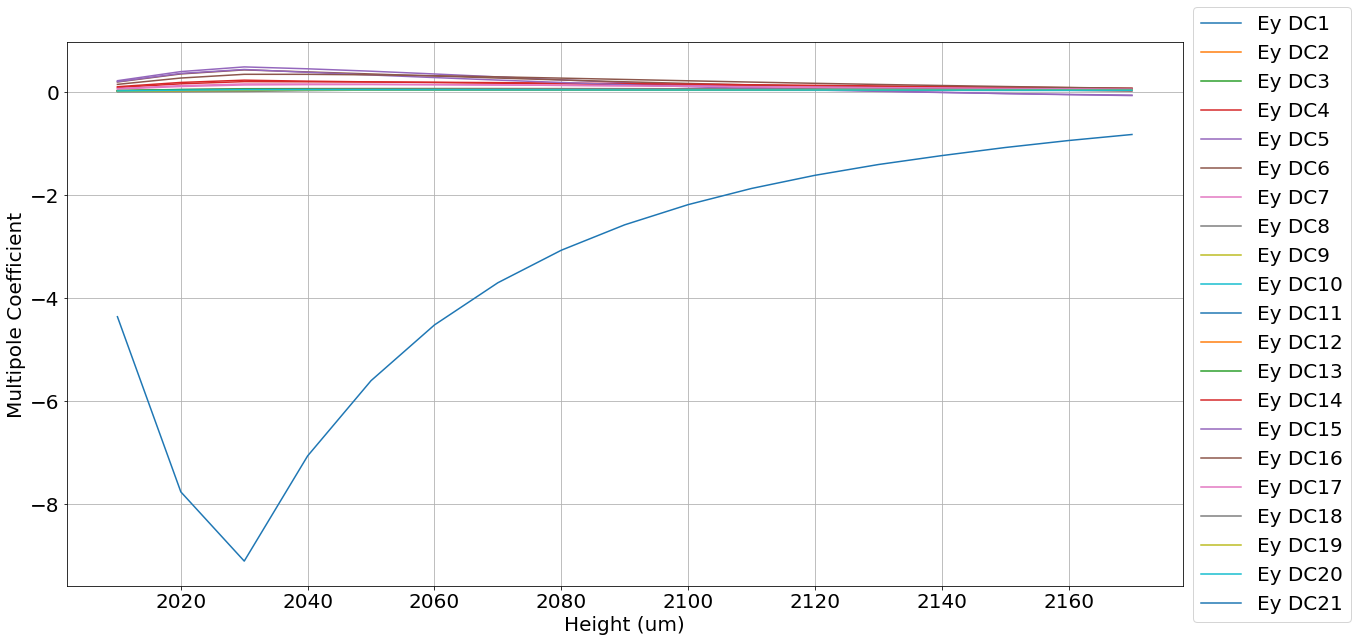

In [30]:
ys = np.round(trap['Y'][nROI:] * 1e3)
numMultipoles = len(s.multipole_print_names)
numElectrodes = len(s.electrode_names)
numYs = len(ys)
multipoles_vs_ys = np.zeros((numYs, numMultipoles, numElectrodes))



# multipoles_vs_height


for i, h in enumerate(ys):
    position = [xl, h*1e-3, zl]
    s.update_origin_roi(position, roi)
    multipoles_vs_ys[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])
    

fig, ax = plt.subplots(figsize=(20,10))

for i in range(len(s.electrode_names)):
    ax.plot(ys, multipoles_vs_ys[:,1,i], label=f'{s.multipole_names[1]} {s.electrode_names[i]}')

ax.set_xlabel('Height (um)')
ax.set_ylabel('Multipole Coefficient')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

plt.savefig('multipoles.png', bbox_inches='tight')
plt.show()


In [31]:
zs = np.round(trap['Z'][nROI:] * 1e3)
numMultipoles = len(s.multipole_print_names)
numElectrodes = len(s.electrode_names)
numZs = len(zs)
multipoles_vs_zs = np.zeros((numZs, numMultipoles, numElectrodes))



# multipoles_vs_height

for i, h in enumerate(zs):
    position = [xl, yl, h*1e-3]
    s.update_origin_roi(position, roi)
    multipoles_vs_zs[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])
    


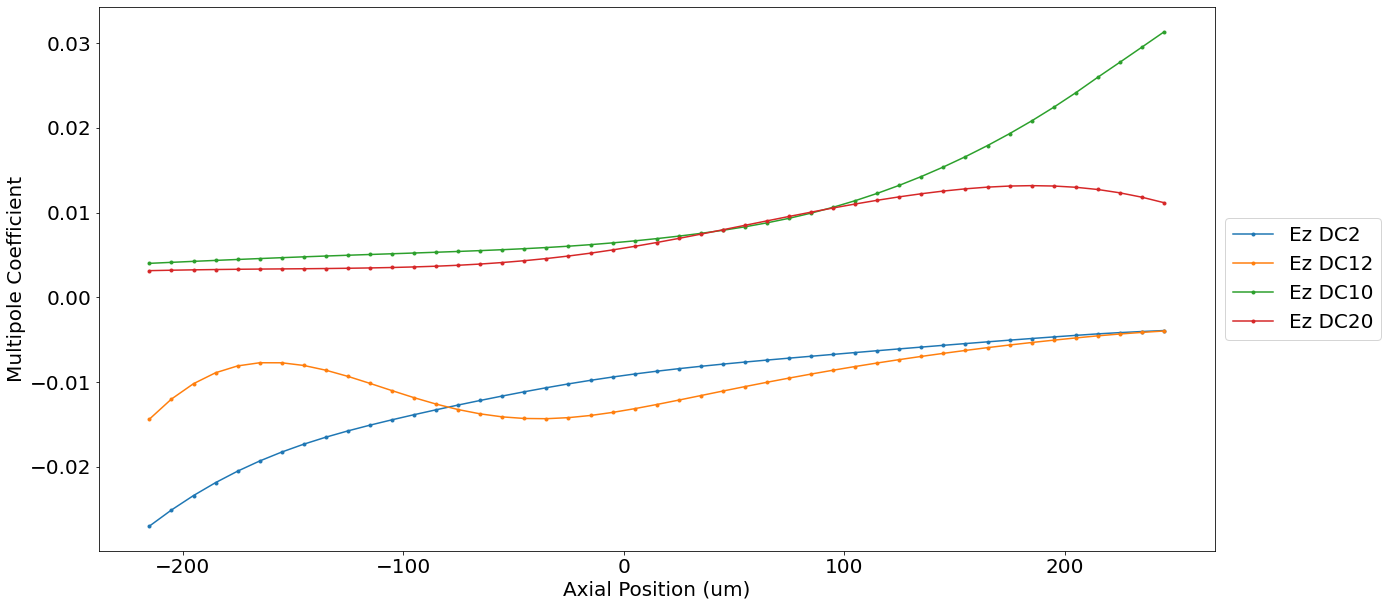

In [32]:
fig, ax = plt.subplots(figsize=(20,10))

for i in [1,11,9,19]:
    ax.plot(zs, multipoles_vs_zs[:,2,i], '.-', label=f'{s.multipole_names[2]} {s.electrode_names[i]}')

ax.set_xlabel('Axial Position (um)')
ax.set_ylabel('Multipole Coefficient')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('multipoles.png', bbox_inches='tight')
plt.show()